In [4]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import SVG

import cv2
from keras.applications import *
from keras.applications.inception_v3 import preprocess_input
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.regularizers import *
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm


In [5]:
# Loading Datasets

df = pd.read_csv('labels.csv')
df.head()

n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:44<00:00, 228.63it/s]


In [12]:
print(np.shape(X))
print(np.shape(y))

(10222, 299, 299, 3)
(10222, 120)


In [19]:
x = X/255.

TypeError: No loop matching the specified signature and casting
was found for ufunc true_divide

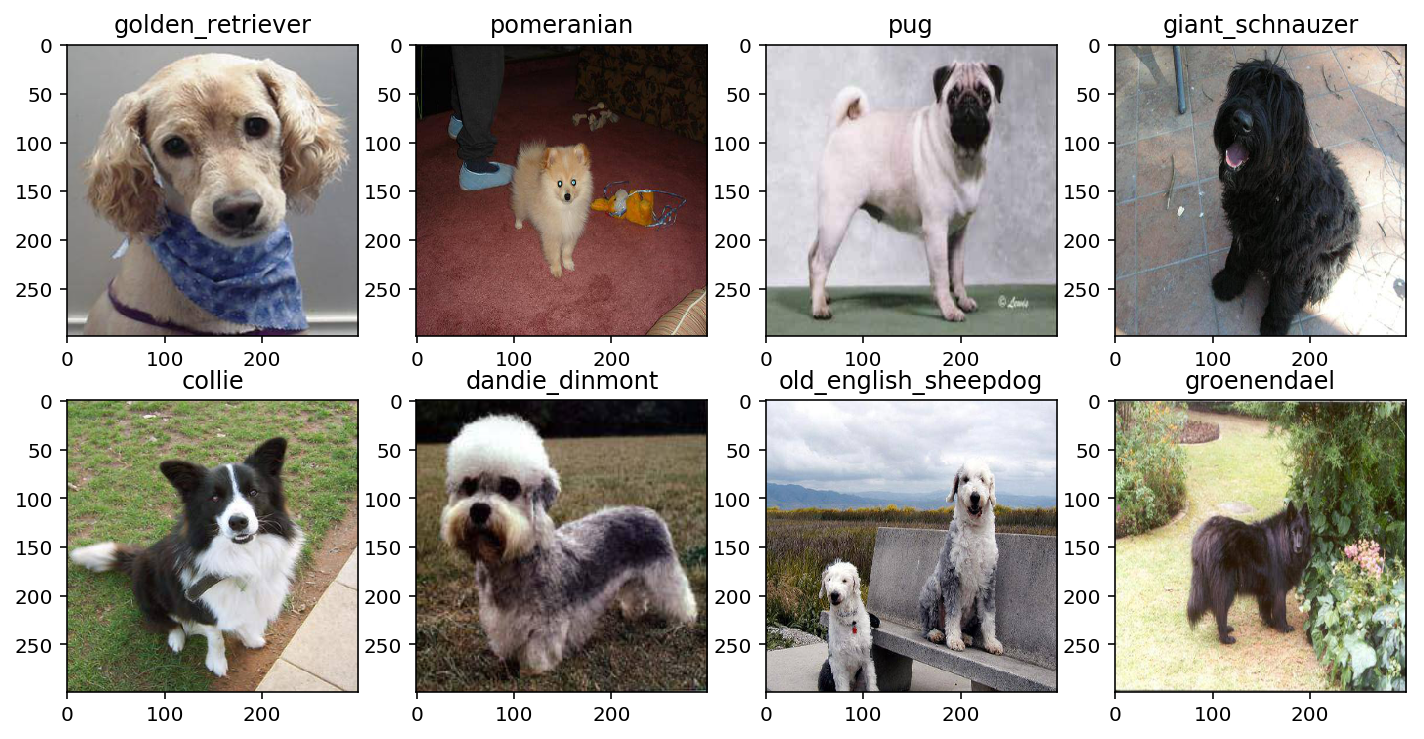

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])


In [18]:
# Computing feature

def get_features(MODEL, data=X):
    cnn_model = MODEL(
        include_top=False, input_shape=(width, width, 3), weights='imagenet')

    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [ ]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)